<a id ='1.0'></a>
<p style="background-color:lightgreen; font-family:newtimeroman; font-size:150%; text-align:center">AC Required Operating Capacity</p>

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:80%; text-align:center">TimeSeries Decomposition</p>

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

* **Level**: The average value in the series.
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Noise**: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:
* **Additive**: $y(t) = Level + Trend + Seasonality + Noise$
* **Multiplicative**: $y(t) = Level * Trend * Seasonality * Noise$

In this case we are going to use function seasonal_decompose() from the statsmodels library.

In [266]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Loading and Visualizing data

In [247]:
col = ['Time','AC Primary Load','Grid Purchases','AC Operating Capacity','AC Required Operating Capacity']
df = pd.read_csv('DATA SET.csv')
cols = df.columns 
df = df[col]
df.set_index(pd.to_datetime(df['Time']), inplace=True)

In [248]:
mean_data = df.groupby(pd.Grouper(freq='1D')).mean()
data=pd.DataFrame(mean_data[col[4]]) # AC REquired Operating Capacity

#### Setting Data manipulation

In [249]:
#Feature Engineering
data['month'] = pd.DatetimeIndex(data.index).month

data.loc[data['month']==1, [col[4]]] *= 0.79
data.loc[data['month']==2, [col[4]]] *= 0.75
data.loc[data['month']==3, [col[4]]] *= 0.75
data.loc[data['month']==4, [col[4]]] *= 0.75
data.loc[data['month']==5, [col[4]]] *= 0.76
data.loc[data['month']==6, [col[4]]] *= 0.78
data.loc[data['month']==7, [col[4]]] *= 0.85
data.loc[data['month']==8, [col[4]]] *= 0.81
data.loc[data['month']==9, [col[4]]] *= 0.77
data.loc[data['month']==10, [col[4]]] *= 0.75
data.loc[data['month']==11, [col[4]]] *= 0.74
data.loc[data['month']==12, [col[4]]] *= 0.83

<AxesSubplot:title={'center':'AC Required Operating Capacity'}, xlabel='Time'>

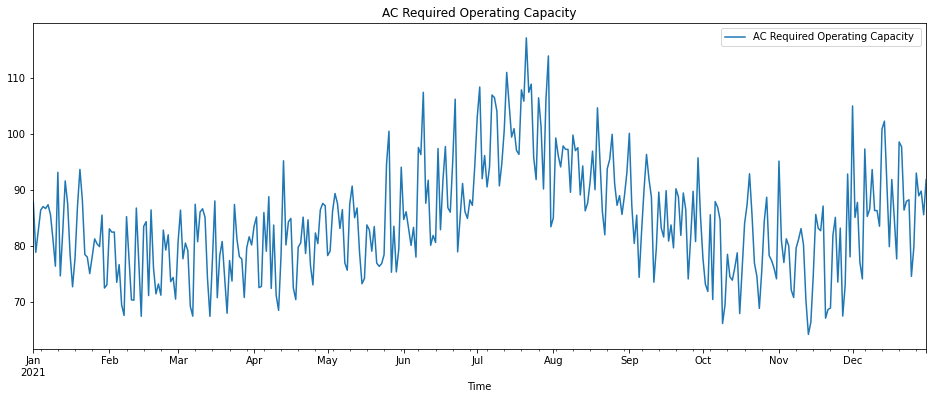

In [250]:
data = data[col[4]]
data.plot(figsize=(16,6), title='AC Required Operating Capacity', legend=True, label='AC Required Operating Capacity ')

#### Is the data stationary?

In [251]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(data)
#Data is Not stationary...

(0.6895071098021017, True)

#### Dickey-Fuller test

In [252]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(data)
print("pvalue = ", pvalue, " if above 0.05, data is not stationary")
#Since data is not stationary, we may need SARIMA and not just ARIMA

pvalue =  0.34040646214789044  if above 0.05, data is not stationary


<a ></a>
## <p style="background-color:skyblue; font-family:newtimeroman; font-size:120%; text-align:center"> Autocorrelation Analysis</p>

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the **autocorrelation function (ACF)** and **partial autocorrelation (PACF)** plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

* **Autocorrelation Function (ACF)**: P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
* **Partial Autocorrelation Function (PACF)**: D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plots help in detecting seasonality.

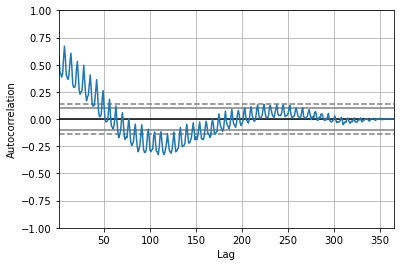

In [263]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data)
plt.show()

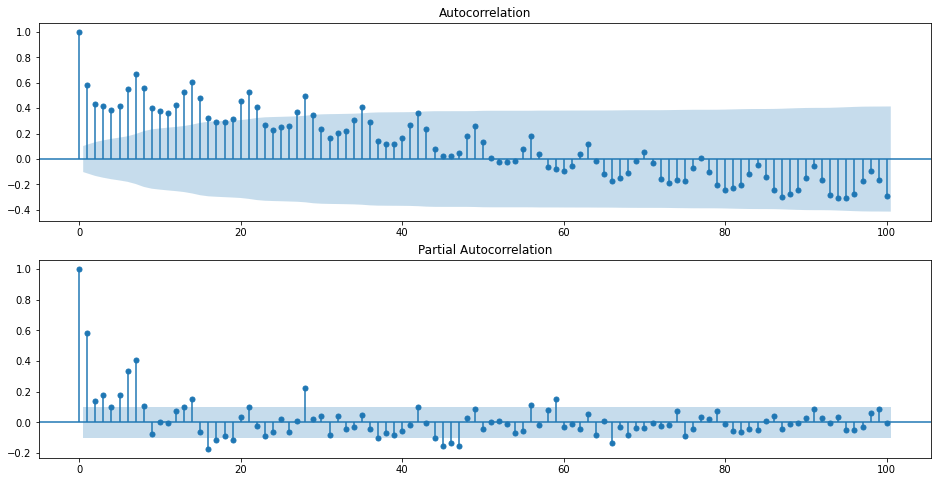

In [264]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(data, lags=100, ax=ax[0])
plot_pacf(data, lags=100, ax=ax[1])

plt.show()

#### Plot trend, seasonal and residuals

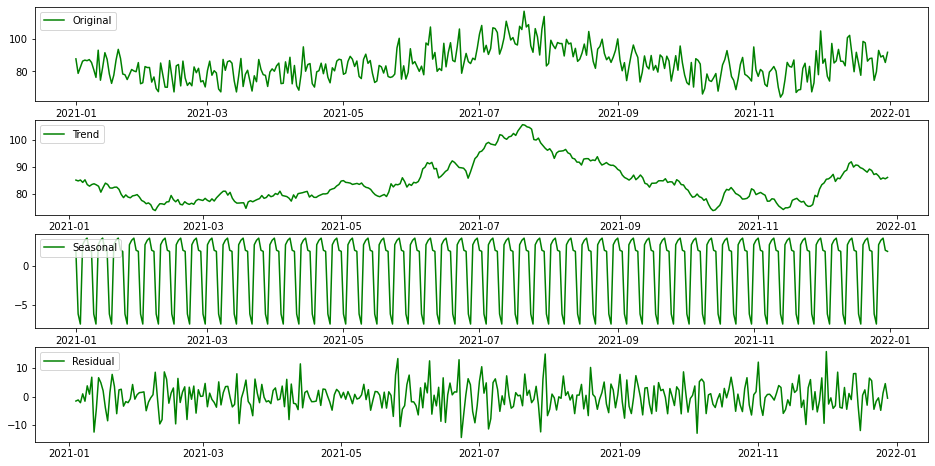

In [253]:
from statsmodels.tsa.seasonal import seasonal_decompose 
decomposed = seasonal_decompose(data,  
                            model ='additive')

trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

plt.figure(figsize=(16,8))
plt.subplot(411)
plt.plot(data, label='Original', color='green')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='green')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='green')
plt.legend(loc='upper left')
plt.show()

## <p style="background-color:skyblue; font-family:newtimeroman; font-size:100%; text-align:center">ARIMA</p>

ARIMA.

The Auto-Regressive Integrated Moving Average (ARIMA) model describes the **autocorrelations** in the data. The model assumes that the time-series is **stationary**. It consists of three main parts:
* <font color='purple'>Auto-Regressive (AR) filter (long term)</font>: 
    
    $\color{purple}{y_t = c + \alpha_1 y_{t-1} + \dots \alpha_{\color{purple}p}y_{t-\color{purple}p} + \epsilon_t = c + \sum_{i=1}^p{\alpha_i}y_{t-i} + \epsilon_t}$  -> p
* <font color='orange'> Integration filter (stochastic trend)</font>
    
    -> d
* <font color='blue'>Moving Average (MA) filter (short term)</font>:

    $\color{blue}{y_t = c + \epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q} = c + \epsilon_t + \sum_{i=1}^q{\beta_i}\epsilon_{t-i}} $  -> q 


**ARIMA**: $y_t = c + \color{purple}{\alpha_1 y_{t-1} + \dots + \alpha_{\color{purple}p}y_{t-\color{purple}p}} + \color{blue}{\epsilon_t + \beta_1 \epsilon_{t-1} + \dots + \beta_{q} \epsilon_{t-q}}$


ARIMA(
<font color='purple'>p</font>,
<font color='orange'>d</font>,
<font color='blue'>q</font>)

* <font color='purple'>p</font>: Lag order (reference  PACF in [Autocorrelation Analysis]
* <font color='orange'>d</font>: Degree of differencing. (reference  Differencing in [Stationarity]
* <font color='blue'>q</font>: Order of moving average (check out ACF in [Autocorrelation Analysis]

### Steps to analyze ARIMA

* **Step 1 — Check stationarity**: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. .
* **Step 2 — Difference**: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
* **Step 3 — Filter out a validation sample**: This will be used to validate how accurate our model is. Use train test validation split to achieve this
* **Step 4 — Select AR and MA terms**: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
* **Step 5 — Build the model**: Build the model and set the number of periods to forecast to N (depends on your needs).
* **Step 6 — Validate model**: Compare the predicted values to the actuals in the validation sample.

#### Find Best ARIMA/SARIMAX

In [ ]:
#We can go through the exercise of making the data stationary and performing ARIMA
#Or let auto_arima provide the best model (e.g. SARIMA) and parameters. 
#Auto arima suggests best model and parameters based on 
#AIC metric (relative quality of statistical models)

from pmdarima.arima import auto_arima
#Autoarima gives us bet model suited for the data
# p - number of autoregressive terms (AR)
# q - Number of moving avergae terms (MA)
# d - number of non-seasonal differences
#p, d, q represent non-seasonal components
#P, D, Q represent seasonal components
arima_model = auto_arima(data, start_p = 1, d=1, start_q = 1, 
                          max_p = 5, max_q = 5, max_d=5, m = 12, 
                          start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, 
                          trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True, n_fits=50) 

In [136]:
# To print the summary 
print(arima_model.summary() ) #Note down the Model and details.

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  365
Model:             SARIMAX(1, 1, 2)x(4, 1, 2, 12)   Log Likelihood               -1208.647
Date:                            Sat, 09 Oct 2021   AIC                           2437.295
Time:                                    02:34:23   BIC                           2475.931
Sample:                                         0   HQIC                          2452.670
                                            - 365                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7651      0.173     -4.426      0.000      -1.104      -0.426
ma.L1         -0.0163      0.156   

<a id ='2.0'></a>
<p style="background-color:lightgreen; font-family:newtimeroman; font-size:150%; text-align:center">(A) Predicting</p>

In [254]:
#Split data into train and test
size = int(len(data) * 0.66)
X_train, X_test = data[0:size], data[size:len(data)]

#### Model fitting

In [255]:
# Fit a  SARIMAX(1, 1, 2)x(4, 1, 2, 12)
from statsmodels.tsa.statespace.sarimax import SARIMAX 
model = SARIMAX(X_train,  
                order = (1, 1, 2),  
                seasonal_order =(4, 1, 2, 12))  #change seasonal MA to 0 for testing better results
  
result = model.fit() 
#result.summary() 

#### Train prediction

In [256]:
start_index = 0
end_index = len(X_train)-1
train_prediction = result.predict(start_index, end_index) 

#### Test Prediction

In [257]:
#Prediction
start_index = len(X_train)
end_index = len(data)-1
prediction = result.predict(start_index, end_index).rename('AC Required Operating Capacity')

<AxesSubplot:title={'center':'AC Required Operating Capacity Test Vs. Predicted'}, xlabel='Time'>

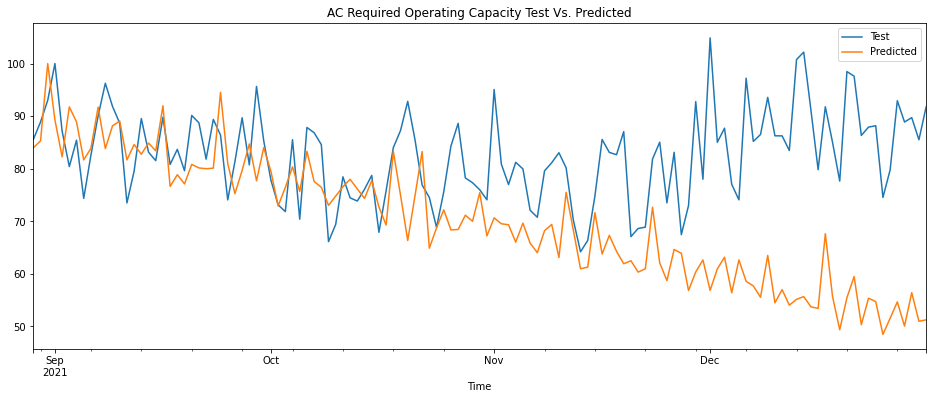

In [258]:
# plot predictions and actual values 
X_test.plot(figsize=(16,6), label='Test', title = 'AC Required Operating Capacity Test Vs. Predicted', legend = True) 
prediction.plot(label = 'Predicted', legend = True) 

#### How valid is our model?

In [259]:
import math
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(X_train, train_prediction))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(X_test, prediction))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 9.57 RMSE
Test Score: 19.02 RMSE


<a id ='3.0'></a>
<p style="background-color:lightgreen; font-family:newtimeroman; font-size:150%; text-align:center">(B) Forecasting</p>

In [260]:
#Forecast.. re-train on the entire dataset before forecasting 
model = SARIMAX(data,  
                order = (1, 0, 1),  
                seasonal_order =(4, 1, 0, 12))  #change seasonal MA to 0 for testing better results
  
result = model.fit()

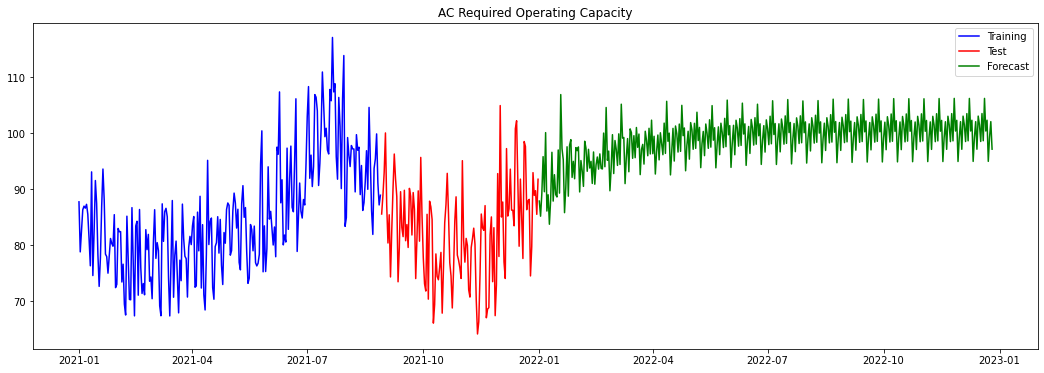

In [261]:
# Forecast for the next 1 years
forecast = result.predict(start = len(data),  
                          end = (len(data)-1) + 30 * 12,  
                          typ = 'levels').rename('Forecast') 
  
plt.figure(figsize=(18,6))
plt.title('AC Required Operating Capacity')
plt.plot(X_train, label='Training', color='blue')
plt.plot(X_test, label='Test', color='red')
plt.plot(forecast, label='Forecast', color='green')
plt.legend(loc='best')
plt.show()

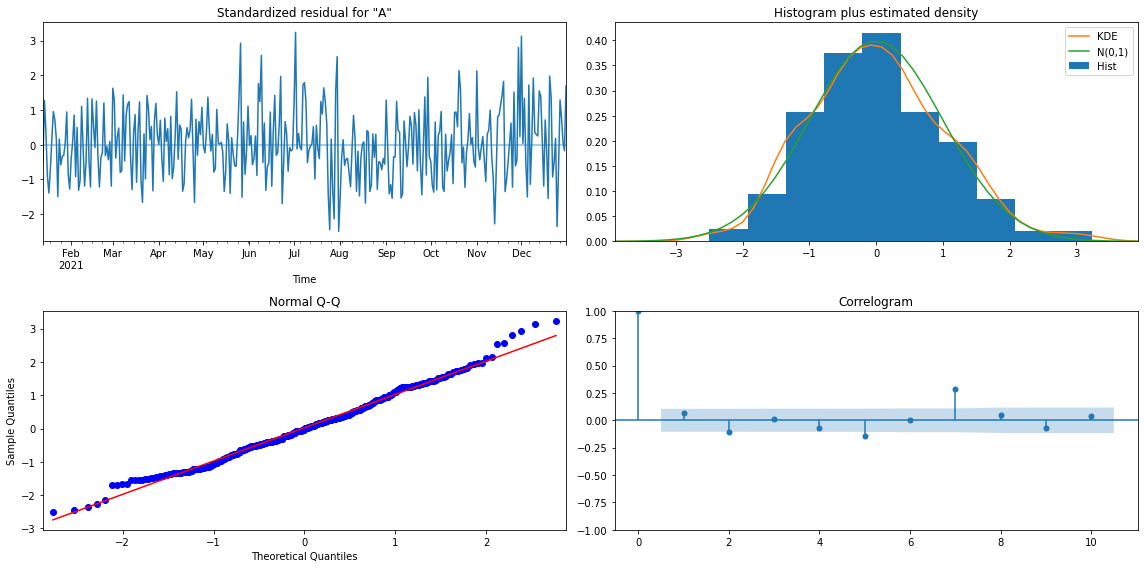

In [262]:
#Model Evaluation
result.plot_diagnostics(figsize=(16,8))
plt.tight_layout()
plt.show()

So how to interpret the plot diagnostics?

* **Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-4, 4).

* **Top Right**: The density plot suggest normal distribution with mean zero.

* **Bottom left**: The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed (not skewed for me).

* **Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.